<a href="https://colab.research.google.com/github/GeorgeWilliam1999/XAI-Project/blob/main/Quantum_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qulacs
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

In [2]:
import qulacs
import numpy as np
from qulacs import QuantumState
from qulacs.gate import X, RY, RZ, DenseMatrix
from sklearn.datasets import load_iris
import seaborn as sns

# QML
## Parameterised quantum circuit set up

The goal here is to recreate a circuit from Dominics thesis,

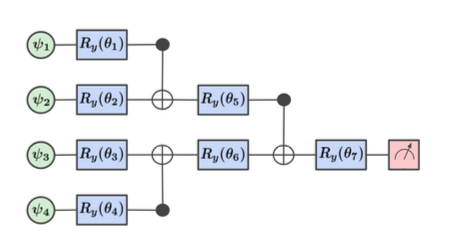

This circuit is able to perform binary classification of data.

## Iris data

In [3]:
#Load and view iris data set
iris = load_iris()
iris.DESCR

'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ============== ==== =

In [4]:
iris.data.shape,iris.target.shape

((150, 4), (150,))

In [5]:
#Load iris data and classification to the same array.
features = iris.feature_names
data = np.zeros((150,5))
data[:,0:4] = iris.data
data[:,4] = iris.target

In [6]:
features

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

In [8]:
colors = {0:'red', 1:'green', 2:'blue'}

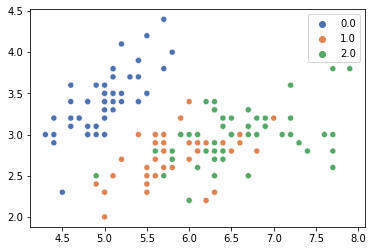

In [9]:
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

# Data preprocessing and embedding

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100, 4), (50, 4), (100,), (50,))

The data array has the form (x,y), where x is the feature vector and y is tge label. The feature vector has 4 element and the labels are 0,1,2 respectivly. To use a parameterised quantum circuit each data vector x must be transformed to a tensor product of qubits.

Encoding this data into qubits can be done in a number of ways. To begin with I will repeat the work done by Dominic, and use the qubit embedding $x_n^d \mapsto \bigotimes_{n=1}^4 cos(x_n^d) |0> + sin(x_n^d) |1>$ where $x_n^d$ is the nth feature of the dth sample. Note that this embedded state is the tensor product of 4 qubits, which gives a state vector of size $2^4 = 16$. Note also that for the qubit embedding we require all the x values be in the range $[0,\frac{\pi}{2})$.

To encode the data I will initialise 4 cubits in the $|0>$ computational basis state and operate on each them with the gate $U(X_n^d) := e^{-ix_n^d\sigma_y}$. This process will encode a single data points.

But first, the data will need normalising as described above.

Test train split

In [11]:
#This function takes a data set and returns a qubit embedding of the data.
#Normalise from the bottom
def half_pi_norm(data):
  #Normalise data
  dim = data.shape[1]
  largest_values = np.zeros(dim)
  for i in range(dim):
    largest_values[i] = np.amax(data[:,i])
  #Normalise classical data
  normalised_data = np.zeros((data.shape[0],dim))
  for i in range(dim):
    normalised_data[:,i] = data[:,i]*(np.pi/(2*largest_values[i]))

  return normalised_data

In [12]:
normed_train_data = half_pi_norm(X_train)
normed_test_data = half_pi_norm(X_test)

# Create the circuit

## Embedding circuit

Now I create the embedding circuit as a function that acts on a point and returns a quantum state.

In [13]:
#Function to perform pointwise qubit embedding.
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

## Computational Circuit 

To build two qubit gates one needs to use combinations of single qubit gates and control operations.

I am copy the state after each operation for comparison.

Now its time for a parameterised quantum circuit.

Each two qubit unitary will be specified by two angles

##Try to make a parametric quantum circuit

In [17]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)


  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

Define the cost function:

In [15]:
from qulacs import Observable

In [18]:
circuit = U()
circuit.get_parameter_count()

7

In [22]:
theta_0 = np.random.rand(7)
for i in range(circuit.get_parameter_count()):
  circuit.set_parameter(i,theta_0[i])

In [23]:
circuit.get_parameter

<bound method PyCapsule.get_parameter of *** Quantum Circuit Info ***
# of qubit: 4
# of step : 5
# of gate : 10
# of 1 qubit gate: 7
# of 2 qubit gate: 3
Clifford  : no
Gaussian  : no

*** Parameter Info ***
# of parameter: 7
>

In [24]:
parameter_count = circuit.get_parameter_count()
param = [circuit.get_parameter(ind) for ind in range(parameter_count)]

In [25]:
state_1 = pointwise_qubit_embedding(normed_train_data[0])
state_1.get_vector()

array([ 0.57889987+0.j, -0.38043521+0.j, -0.34882112+0.j,  0.22923452+0.j,
       -0.31051989+0.j,  0.20406413+0.j,  0.18710644+0.j, -0.12296061+0.j,
       -0.25051234+0.j,  0.16462902+0.j,  0.15094838+0.j, -0.09919864+0.j,
        0.13437396+0.j, -0.08830644+0.j, -0.08096819+0.j,  0.05320981+0.j])

In [26]:
state_1.get_vector()

array([ 0.57889987+0.j, -0.38043521+0.j, -0.34882112+0.j,  0.22923452+0.j,
       -0.31051989+0.j,  0.20406413+0.j,  0.18710644+0.j, -0.12296061+0.j,
       -0.25051234+0.j,  0.16462902+0.j,  0.15094838+0.j, -0.09919864+0.j,
        0.13437396+0.j, -0.08830644+0.j, -0.08096819+0.j,  0.05320981+0.j])

In [27]:
state_2 = state_1
circuit.update_quantum_state(state_2)
state_2.get_vector()

array([ 0.1889197 +0.15385961j,  0.18540123+0.15099411j,
        0.03240863-0.05703588j,  0.06971741-0.12269554j,
       -0.26064551-0.07484067j, -0.2557912 -0.07344683j,
       -0.23307995+0.04471605j, -0.50140139+0.09619312j,
        0.03900661+0.06864767j,  0.03828015+0.06736916j,
        0.10373125-0.0844806j ,  0.22314657-0.1817346j ,
       -0.28053208-0.05381967j, -0.2753074 -0.05281732j,
       -0.14311416+0.04109321j, -0.30786706+0.08839967j])

## define operator: Pauli Z:

In [33]:
from qulacs import PauliOperator
p_s = 'Z 2'
z = PauliOperator(p_s,1)

In [34]:
pred = z.get_expectation_value(state_2)

In [48]:
def pred(x, U, theta):
  global circuit
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])
  point = x
  state = pointwise_qubit_embedding(point)
  U().update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 2')
  pred = obs.get_expectation_value(state)
  if pred >= 0.33:
    pred = 2
  elif pred < 0.33 and pred > -0.33:
    pred = 1
  else:
    pred = 0

  return  pred

In [73]:
predictions = []
for i in range(len(normed_train_data)):
  predictions.append(pred(normed_train_data[i],U,theta))

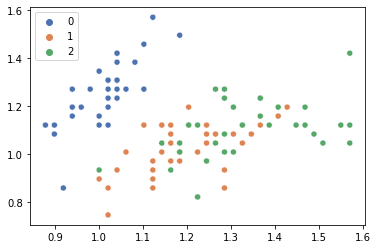

In [75]:
sns.scatterplot(data=normed_train_data, x=normed_train_data[:,0], y=normed_train_data[:,1], hue=y_train, palette="deep")

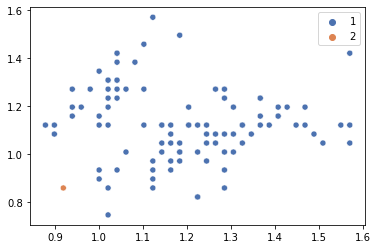

In [76]:
sns.scatterplot(data=normed_train_data, x=normed_train_data[:,0], y=normed_train_data[:,1], hue=predictions, palette="deep")

In [52]:
def cost_train(theta):
  #get predictions
  predictions = np.zeros(normed_train_data.shape[0])
  for i in range(normed_train_data.shape[0]):
    predictions[i] = pred(normed_train_data[i],U, theta)
  #Simple MSE example
  L = ((predictions - y_train)**2).mean()
  return L

In [77]:
cost_train(theta)

0.68

## Optimise

In [78]:
ßfrom scipy.optimize import minimize #BFGS works well/cobyla

In [54]:
#%%time
theta_0 = np.random.rand(7)
# Learning (takes 14 seconds with the writer's PC)
result = minimize(cost_train, theta_0, method='BFGS')

In [44]:
theta = result.x

In [55]:
theta, theta_0

(array([0.79730677, 0.01874448, 0.91351465, 0.73340672, 0.81648231,
        0.59989786, 0.30406923]),
 array([0.63593352, 0.07784245, 0.64998645, 0.9302648 , 0.43048752,
        0.03883032, 0.28146073]))

In [58]:
def cost_test(theta):
  #get predictions
  predictions = np.zeros(normed_test_data.shape[0])
  for i in range(normed_test_data.shape[0]):
    predictions[i] = pred(normed_test_data[i],U,theta)
  #Simple MSE example
  L = ((predictions - y_test)**2).mean()
  return L

In [59]:
cost_test(theta)

0.7

In [63]:
predictions = np.zeros(normed_test_data.shape[0])
for i in range(normed_test_data.shape[0]):
  predictions[i] = pred(normed_test_data[i],U, theta)


In [64]:
y_test - predictions

array([ 0., -1.,  1.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  1., -1., -1.,
       -1., -1.,  0.,  1.,  0.,  0.,  1., -1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1.,  0., -1., -1.,  1.,  0., -1., -1.,
       -1.,  1.,  0.,  0., -1., -1.,  0.,  1.,  1.,  0.,  1.])

In [65]:
#find accuracy
accuracy = sum(abs(y_test - predictions))/len(y_test)
accuracy

0.7

# Binary Classification attempt

In [ ]:
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

In [ ]:
sns.scatterplot(data=data, x=data[:,2], y=data[:,3], hue=data[:,4], palette="deep")

In [ ]:
#Copy data and alter labels for binar classification.
y_test_bi = y_test
y_train_bi = y_train

X_test_bi = X_test
X_train_bi = X_train

for i in range(len(y_test)):
  if y_test[i] == 2:
    y_test_bi = 1

for i in range(len(y_train)):
  if y_train[i] == 2:
    y_train_bi = 1


In [ ]:
normed_train_data_bi = half_pi_norm(X_train_bi)
normed_test_data_bi = half_pi_norm(X_test_bi)

In [ ]:
def pred_bi(x, U):
  global circuit
  point = x
  state = pointwise_qubit_embedding(point)
  U(theta).update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 2')
  pred = obs.get_expectation_value(state)
  if pred >= 0:
    pred = 1
  else:
    pred = 0

  return  pred

# Isling model example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [ ]:
########  Parameter  #############
nqubit = 3 ## number of qubit
c_depth = 3 ## depth of circuit
time_step = 0.77  ## elapsed time of time evolution with random Hamiltonian

## randomly take num_x_train points from [x_min, x_max] as teacher data.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## one variable function to learn
func_to_learn = lambda x: np.sin(x*np.pi)

## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)

In [ ]:
#### Prepare teacher data
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# Add noise to pure sine function assuming real data used
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [ ]:
# Create intial state
from qulacs import QuantumState, QuantumCircuit

state = QuantumState(nqubit) # Initial state |000>
state.set_zero_state()
print(state.get_vector())

In [ ]:
# Function that creats a gate encoding x
def U_in(x):
    U = QuantumCircuit(nqubit)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)

    return U

In [ ]:
# Test initial state
x = 0.1 # appropriate value
U_in(x).update_quantum_state(state) # calculation of U_in|000>
print(state.get_vector())

$ 
H = \sum_{i = 1}^N a_i X_i + \sum_{i = 1}^N \sum_{k = 1}^{i-1}J_{i,k}Z_jZ_k
$

In [ ]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

In [ ]:
## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

In [ ]:
#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

In [ ]:
time_evol_op.shape

In [ ]:
# Convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

## Create rotation gates and evolution operator

In [ ]:
from qulacs import ParametricQuantumCircuit

In [ ]:
# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

In [ ]:
# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

In [ ]:
theta_init

In [ ]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

## Measurement

In [ ]:
# Create observable Z_0
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2.,'Z 0')
# Set observable as 2*Z。
# The reason for multiplying by 2 here is to expand the value range of the final <Z>.
# In order to cope with any unknown function, this constant also needs to be optimized as one parameter.

In [ ]:
obs.get_expectation_value(state)

In [ ]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(x).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res = obs.get_expectation_value(state)

    return res

## Cost 

In [ ]:
# Calculate cost function L
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    y_pred = [qcl_pred(x, U_out) for x in x_train]

    # quadratic loss
    L = ((y_pred - y_train)**2).mean()

    return L

In [ ]:
# Value of cost function with initial parameter theta
cost_func(theta_init)

In [ ]:
# Figure basing on inital parameter theta
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

## Learning

In [ ]:
from scipy.optimize import minimize

In [ ]:
result = minimize(cost_func, theta_init, method='Nelder-Mead')

In [ ]:
# Value of cost_function after optimization
result.fun

In [ ]:
print(theta_init)

In [ ]:
# Solution of theta by optimization
theta_opt = result.x
print(theta_opt)

#Plot results

In [ ]:
# Insert optimized theta into U_out
set_U_out(theta_opt)

In [ ]:
# Plot
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# teacher data
plt.plot(x_train, y_train, "o", label='Teacher')

# Figure basing on inital parameter theta
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# Prediction of the model
y_pred = np.array([qcl_pred(x, U_out) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()